# UNISACSI Examples

This notebook contains a set of example scripts showing how the functions of the unisacsi package can be used to read data collected during fieldwork and create plots.

## Importing packages, setting paths, ...

As in every Python script, first import all packages needed for the following code:

In [2]:
import unisacsi.Ocean as Oc
import unisacsi.Meteo as Met
from unisacsi.MET_model_download import download_MET_model_static_fields, download_MET_model_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import gsw
import cmocean as cmo

ImportError: cannot import name 'split_ADCP_resolution' from 'unisacsi.Ocean' (/Users/lukasf/Documents/GitHub/unisacsi/unisacsi/Ocean.py)

Then, download the folder with the example and map data and save it locally on your computer. Then, specify this location here:

In [ ]:
path_data = "/Users/lukasf/OneDrive - Universitetssenteret på Svalbard AS/unisacsi_example_data/"

Now you are ready to dive into the actual examples!

## Oceanography

### CTD

You can use the read_CTD function from the Ocean module of unisacsi to read one or several CTD data file. If you are unsure how to use it, simply check the docs using the help function (PS: this works for any Python function, if the creator has included documentation):

In [ ]:
help(Oc.read_CTD)

As you now know which arguments the function expects, you can use it:

In [3]:
CTD = Oc.read_CTD(f"{path_data}CTD/")

CTD is a dictionary with one entry per station. Therefore, the keys of CTD are the station numbers:

In [4]:
print(CTD.keys())

dict_keys([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 157, 158, 159, 31, 160, 161, 162, 74, 163, 164, 315, 316, 317, 318, 319, 320, 321, 241, 32, 33, 988, 165, 34, 166, 167, 168, 70, 169, 170, 171, 35, 36, 37, 987, 38, 39, 172, 173, 174, 40, 62, 63, 64, 65, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 991, 501, 502, 503, 504, 505, 506, 507, 508, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 196, 195, 194, 193, 192, 191, 190, 206, 205, 204, 203, 202, 201, 200])


In [8]:
print(CTD[3]["gps_datetime"])

Feb 19 2002  11:15:51


Each station is again a dictionary with the variables as keys. Therefore, you can check the list of variables for one particular station using:

In [7]:
print(CTD[12].keys())

dict_keys(['P', 'D', 'T', 'C', 'OX', 'TURB', 'PAR', 'S', 'Tpot', 'OXsat', 'sbe_model', 'gps_datetime', 'seasave', 'instrument_type', 'nquan', 'nvalues', 'start_time', 'bad_flag', 'file_type', 'md5', 'datetime', 'filename', 'dnum', 'LAT', 'LON', 'z', 'BottomDepth', 'SA', 'CT', 'SIGTH', 'st', 'unis_st'])


In order to define a certain section, e.g. the along-fjord section in Isfjorden or Storfjorden, create a list with the corresponding station numbers (in the correct order):

In [8]:
storfjorden_section = list(range(501,509))

Now you can plot e.g. the density profiles from all stations in the Storfjorden section using the following bit of code:

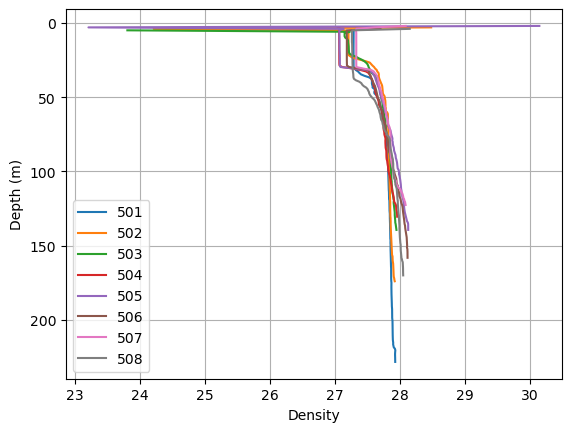

In [9]:
plt.figure()
for station in storfjorden_section:
    plt.plot(CTD[station]['SIGTH'],-CTD[station]['z'],label=station)
plt.gca().invert_yaxis()
plt.xlabel('Density')
plt.ylabel('Depth (m)')
plt.grid()
plt.legend()

For many purposes, having the data stored in nested dictionaries is not very practical. There is two ways of how to re-order the data. You can either convert the data from a single station into a pandas dataframe, with the depth as the index and the variables as columns...

In [10]:
station_df = pd.DataFrame(CTD[12])
station_df.index = -station_df['z']
print(station_df)

               P       D       T         C      OX    TURB      PAR  \
z                                                                     
2.968386     3.0   2.970  3.6025  30.11518  6.8519  17.064  0.67389   
3.957839     4.0   3.954  3.6392  30.06276  7.2481  15.673  0.46110   
4.947286     5.0   4.950  3.5819  30.02019  7.2478  14.217  0.34071   
5.936729     6.0   5.935  3.5750  30.01437  7.2245  13.445  0.27990   
6.926167     7.0   6.928  3.5756  30.01514  7.2355  13.306  0.22545   
...          ...     ...     ...       ...     ...     ...      ...   
94.966930   96.0  94.968 -1.3378  27.70869  6.9921  10.083      NaN   
95.955936   97.0  95.956 -1.3594  27.69210  6.9858  10.287      NaN   
96.944938   98.0  96.946 -1.3693  27.68462  6.9716  10.603      NaN   
97.933934   99.0  97.936 -1.3720  27.68286  6.9646  10.689      NaN   
98.922926  100.0  99.035 -1.3820  27.67731  6.9607  10.078      NaN   

                   S    Tpot   OXsat  ...        dnum        LAT        LON 

... or you can save the measurements of one particular variable from several stations into a dataframe, again with the depth s index, but the columns now represent the individual stations:

In [11]:
CTD_i,Z,_,_ = Oc.CTD_to_grid(CTD,storfjorden_section,interp_opt=0)
df_oxygen = pd.DataFrame(CTD_i['OX'],index=Z,columns=storfjorden_section)
print(df_oxygen)

                 501       502       503       504       505       506  \
1.979021         NaN       NaN       NaN       NaN       NaN       NaN   
2.981139         NaN  6.542199       NaN  6.413950  6.964152       NaN   
3.983257         NaN  6.975531       NaN  6.756281  7.247674  6.213078   
4.985375         NaN  7.158049  7.568327  7.215174  7.250500  7.317025   
5.987494    7.011507  7.181013  7.211997  7.213146  7.251265  7.308033   
...              ...       ...       ...       ...       ...       ...   
224.449256  6.570204       NaN       NaN       NaN       NaN       NaN   
225.451374  6.558831       NaN       NaN       NaN       NaN       NaN   
226.453492  6.550910       NaN       NaN       NaN       NaN       NaN   
227.455611  6.544389       NaN       NaN       NaN       NaN       NaN   
228.457729  6.526300       NaN       NaN       NaN       NaN       NaN   

                 507       508  
1.979021    6.558000       NaN  
2.981139    6.448603       NaN  
3.983257    

You might want to have a look at a map to see, where the stations are located.

<a list of 203 text.Text objects>


/Users/lukasf/opt/anaconda3/envs/test/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


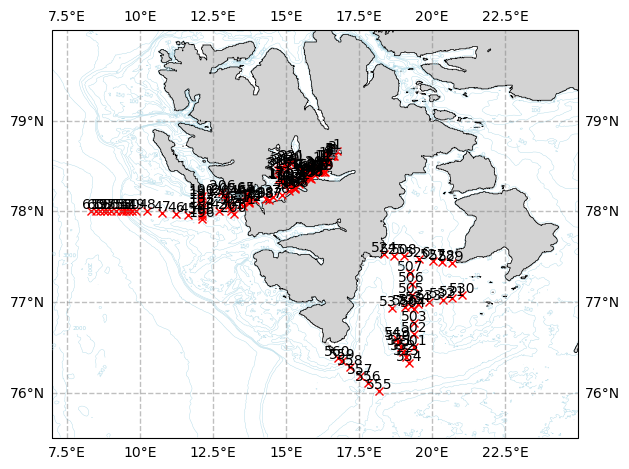

In [12]:
plt.figure()
Oc.plot_CTD_map(CTD, extent=[7.,25.,75.5,80.], topography=f"{path_data}Svalbard_map_data/bathymetry_svalbard.mat")

Like this, the map is not very helpful. Let's focus on the Storfjorden section again:

<a list of 347 text.Text objects>


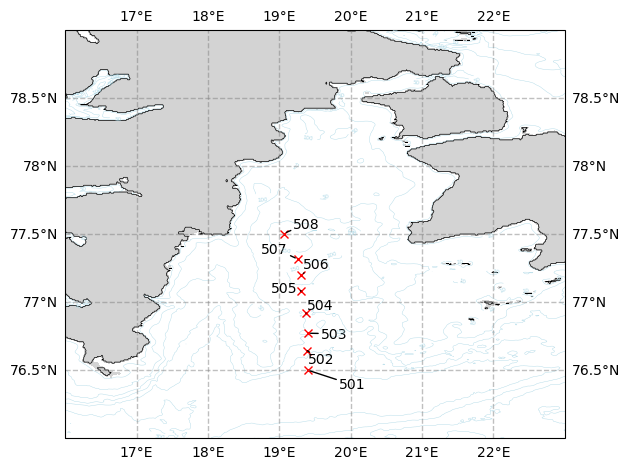

In [13]:
plt.figure()
Oc.plot_CTD_map(CTD, extent=[16.,23.,76.,79.], stations=storfjorden_section, topography=f"{path_data}Svalbard_map_data/bathymetry_svalbard.mat",
                adjust_text=True)

Much better! Are you wondering how the temperature along this section looks like?

(<AxesSubplot:xlabel='Distance [km]', ylabel='Depth [m]'>,
 <matplotlib.contour.QuadContourSet at 0x7fc88dd6f640>)

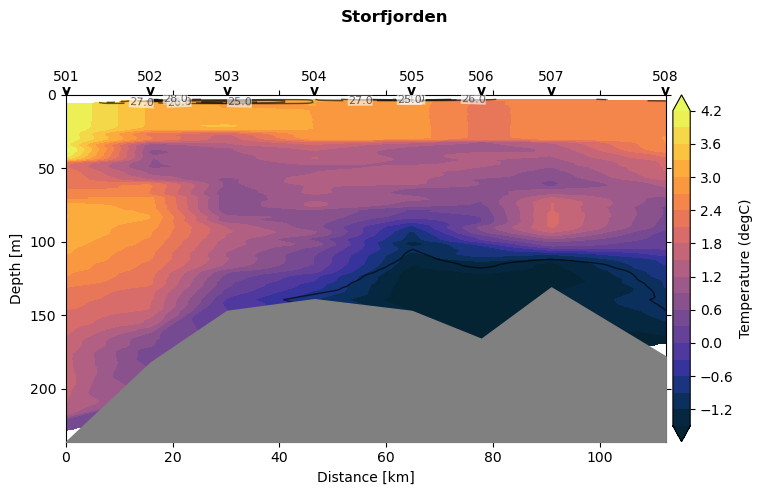

In [14]:
Oc.plot_CTD_single_section(CTD, storfjorden_section, parameter='T',
                               clabel='Temperature (degC)',
                              cmap='cmo.thermal',section_name='Storfjorden')

If you are not a fan of the interpolation, you can simply change the corrspeonding argument in the function call (Check the documentation using the help function!):

(<AxesSubplot:xlabel='Distance [km]', ylabel='Depth [m]'>,
 <matplotlib.contour.QuadContourSet at 0x7fc88da13a90>)

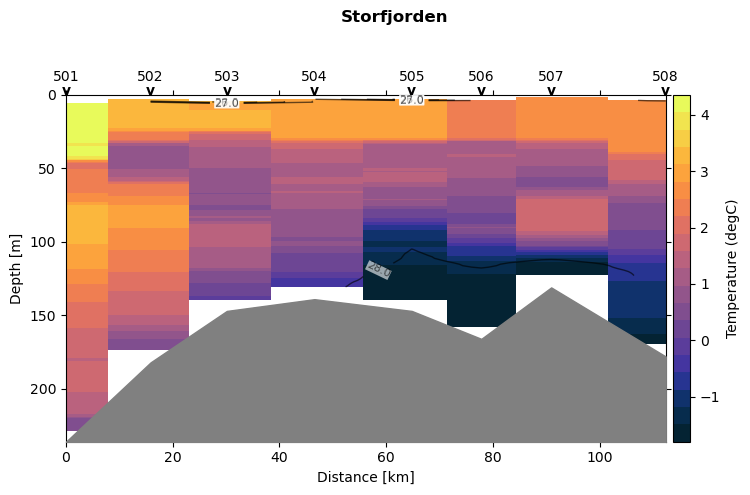

In [15]:
Oc.plot_CTD_single_section(CTD, storfjorden_section, parameter='T',
                               clabel='Temperature (degC)',
                              cmap='cmo.thermal',section_name='Storfjorden', interp_opt=0)

Finally, T-S diagrams are very useful to investigate e.g. the origin and interaction of water masses. A quick way to plot a T-S diagram of all stations in the Storfjorden section is the following function:

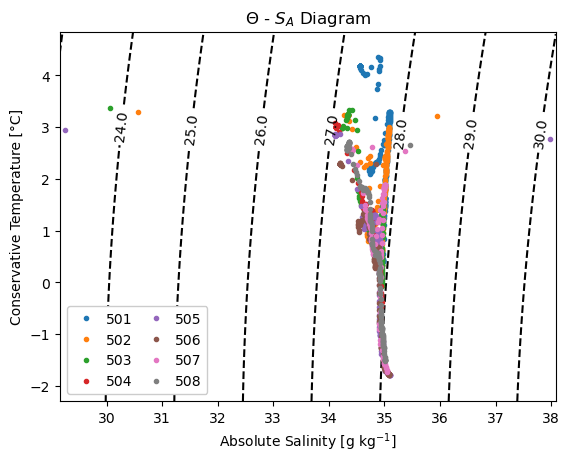

In [16]:
plt.figure()
Oc.plot_CTD_ts(CTD,storfjorden_section)

If you want to adjust the plot to your individual needs, you can simply create an empty T-S diagram first, and then add the data manually. Instead of coloring the dots according to the station they were measured at, you can color them according to e.g. oxygen content instead:

(34.0, 35.5)

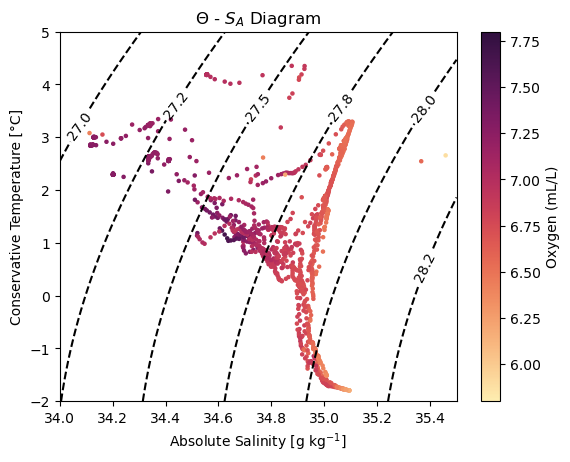

In [17]:
plt.figure()
Oc.create_empty_ts(T_extent=[-2., 5.],S_extent=[34.,35.5])
for station in storfjorden_section:
    S = plt.scatter(CTD[station]['SA'],CTD[station]['CT'],
                s=5,c=CTD[station]['OX'],cmap='cmo.matter',
                   vmin=5.8,vmax=7.8)
plt.colorbar(S,label='Oxygen (mL/L)')
plt.xlim([34.,35.5])

### Mooring

During the AGF-214 cruise, we will recover and re-deploy a set of moorings. which constantly monitor the in- and outflow of water in the mouth of Isfjorden. The following code snippets can help you to handle the data.

The function to read the data again stores it in a dictionary. Let's have a look:

In [18]:
mooring = Oc.read_mooring(f"{path_data}Mooring/IS1617.mat")

print(mooring.keys())

dict_keys(['title', 'summary', 'acknowledgement', 'stat_number', 'authors', 'affiliation', 'roles', 'owner', 'comment', 'references', 'lat', 'lon', 'bdepth', 'deployment', 'project', 'name', 'unit', 'sensor', 'date556', 'date557', 'date558', 'date559', 'date560', 'date5453', 'date7497', 'date7498', 'date408', 'date464', 'date1060', 'T556', 'T557', 'T558', 'T559', 'T560', 'T5453', 'T7497', 'T7498', 'T408', 'T464', 'T1060', 'md556', 'md557', 'md558', 'md559', 'md560', 'md5453', 'md7497', 'md7498', 'md408', 'md464', 'md1060', 'depthcell408', 'P5453', 'P7497', 'P7498', 'P408', 'P464', 'P1060', 'C5453', 'C7497', 'C7498', 'C408', 'C464', 'C1060', 'S5453', 'S7497', 'S7498', 'S408', 'S464', 'S1060', 'D5453', 'D7497', 'D7498', 'D408', 'D464', 'D1060', 'PD5453', 'PD7497', 'PD7498', 'PD408', 'PD464', 'PD1060', 'O408', 'U408', 'U464', 'U1060', 'V408', 'V464', 'V1060', 'W408'])


Some entries are self-explanatory, just have a look yourself, e.g.:

In [19]:
print(mooring["lat"])

78.06073333333333


For all dict entry names, which are a combination of letters and numbers: The number is the serial number of the individual sensor, you can figure out the type of each sensor by having a look at the "sensor"-entry. The letters before the number indicate the type of the variable: T = temperature, S = salinity, C = conductivity, P = pressure, O = oxygen, U,V,W = velocity components, md = measurement depth and data = the time array for the respective sensor. With that knowledge, you can now plot e.g. a timeseries of temperature:

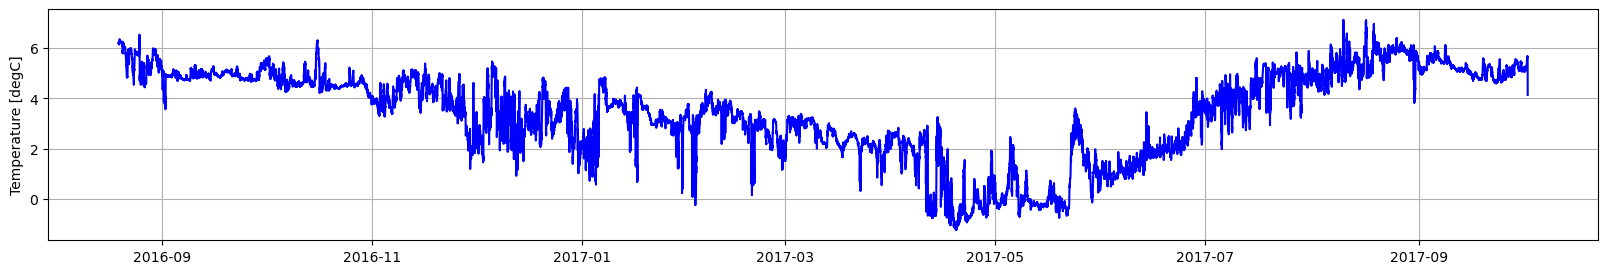

In [20]:
plt.figure(figsize=(20,3))
plt.plot(mooring["date556"], mooring["T556"], "b")
plt.ylabel('Temperature [degC]')
plt.grid()

You might want to look at not only one level, but at a time series of composite profiles combined from all measurements of a certain variable. For that purpose you can use the following function to grid the mooring data from one variable onto a grid defined by the last two arguments ("1H" = one-hourly temporal resolution, 20. = 20 m depth resolution):

Text(0, 0.5, 'temperature [degC]')

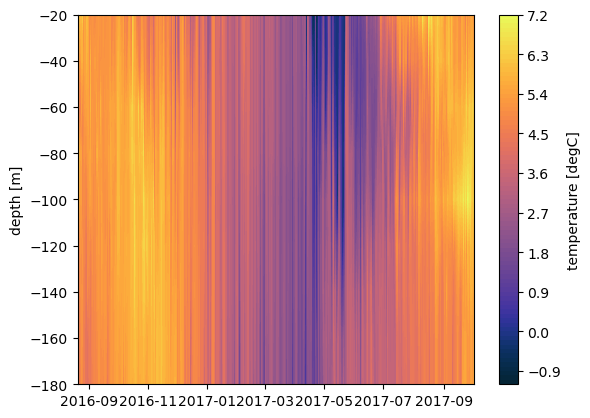

In [21]:
df_levels, df_gridded = Oc.mooring_to_grid(mooring, "T", "1H", 20.)

fig, ax = plt.subplots(1,1)
pic = ax.contourf(df_gridded.index, -1.*np.array(list(df_gridded.columns)), df_gridded.transpose(), levels=100, cmap=cmo.cm.thermal)
ax.set_ylabel("depth [m]")

cbar = plt.colorbar(pic, ax=ax)
cbar.ax.set_ylabel("temperature [degC]")

### ADCP

Ship-mounted ADCP data will be processed by one of the teachers using a software package called CODAS. The resulting data files can be read with the following function:

In [3]:
adcp = Oc.read_ADCP_CODAS(f"{path_data}ADCP/os75bb_short.nc")
print(f"{path_data}ADCP/os75bb_long.nc")

/Users/lukasf/OneDrive - Universitetssenteret på Svalbard AS/unisacsi_example_data/ADCP/os75bb_long.nc


It might be neccessary to limit the time period to a certain section:

In [5]:
adcp_wsc = adcp.sel(time=slice("2022-09-30 13:57","2022-10-01 11:10"))

Now you can the section on a map:

<a list of 240 text.Text objects>


Text(<xarray.DataArray 'lon' ()>
array(8.37355556)
Coordinates:
    lat      float64 78.01
    lon      float64 8.374
    time     datetime64[ns] 2022-10-01T11:09:12
Attributes:
    long_name:      Longitude
    units:          degrees_east
    C_format:       %9.4f
    standard_name:  longitude
    data_min:       8.32698888888889
    data_max:       21.042613888888887, <xarray.DataArray 'lat' ()>
array(78.00532222)
Coordinates:
    lat      float64 78.01
    lon      float64 8.374
    time     datetime64[ns] 2022-10-01T11:09:12
Attributes:
    long_name:      Latitude
    units:          degrees_north
    C_format:       %9.4f
    standard_name:  latitude
    data_min:       76.02328055555556
    data_max:       78.66501666666667, 'B')

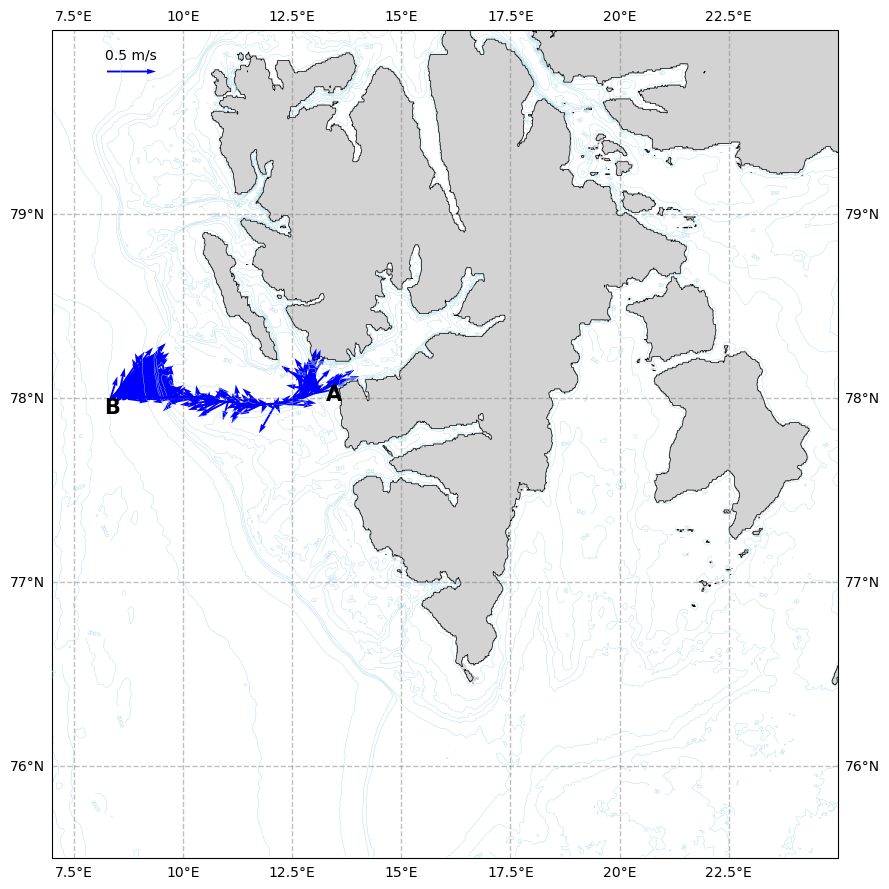

In [9]:
data_proj = ccrs.PlateCarree()
plt.figure(figsize=(9,9))

ax = Oc.plot_empty_map(extent=[7.,25.,75.5,80.], topography=f"{path_data}Svalbard_map_data/bathymetry_svalbard.mat");

# First plot the shiptrack
ax.plot(adcp_wsc.lon,adcp_wsc.lat,transform=data_proj, color='b')

# Then plot the surface velocity as arrows
q = ax.quiver(adcp_wsc.lon,adcp_wsc.lat, adcp_wsc.u.isel(depth_cell=0), adcp_wsc.v.isel(depth_cell=0), scale=8., transform=data_proj, color = 'b')
# Put a legend for the arrows
plt.quiverkey(q,0.1,0.95,0.5,'0.5 m/s',color='blue',labelcolor='black',
                  transform=plt.gca().transAxes)

# Indicate on the map, where the section starts, and where it ends
ax.text(adcp_wsc.lon[0],adcp_wsc.lat[0],'A',transform=data_proj,fontweight='bold',
       horizontalalignment='center',verticalalignment='top',
       fontsize=15)
ax.text(adcp_wsc.lon[-1],adcp_wsc.lat[-1],'B',transform=data_proj,fontweight='bold',
       horizontalalignment='center',verticalalignment='top',
       fontsize=15)

Split the time series into parts with different vertical resolutions:

In [18]:
adcp_wsc_split = Oc.split_ADCP_resolution(adcp_wsc)

Now, you can plot the cross section with the velocities color-coded:

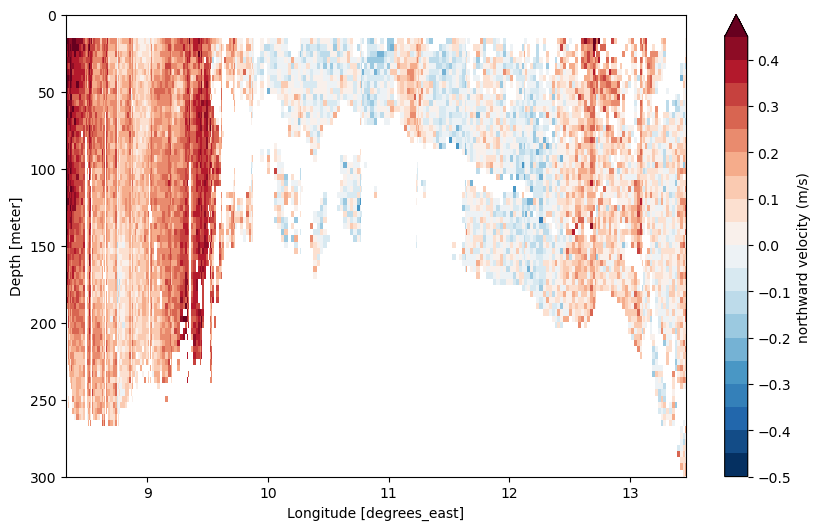

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
for adcp_res in adcp_wsc_split:
    pic = adcp_res.v.sortby("lon").plot(x="lon", y="depth", levels=np.arange(-.5, .5, 0.05), add_colorbar=False)

#Add information and make the map a bit nicer
ax.set_ylim(0,300)
ax.invert_yaxis()
plt.colorbar(pic, ax=ax, label='northward velocity (m/s)')

## Meteorology

### Download AROME-Arctic model data

You can download model data from AROME-Arctic using the following functions. The configurations are set in an extra configuration file (also provided on github)

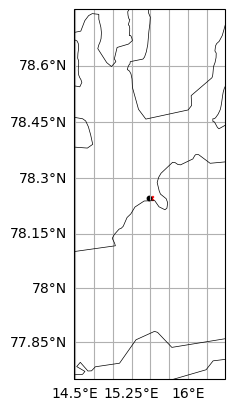

Type 'Y' to proceed to the download. Any other input will terminate the script immediately.

Your input:  N


SystemExit: 1

/Users/lukasf/opt/anaconda3/envs/test/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [26]:
#download_MET_model_static_fields(f"{path_data}AROME_ARCTIC/config_model_download.yml")
download_MET_model_data(f"{path_data}AROME_ARCTIC/config_model_download.yml")

### Time series plots

Most of the data we sample during the meteorology fieldwork is simple time series data. Functions to read the data are available in the Meteo module (Check the docs!). The following code is just an example of how to read and plot the data from a radiometer or several Tinytags:

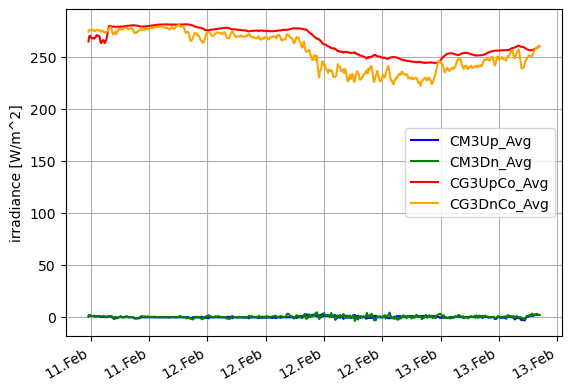

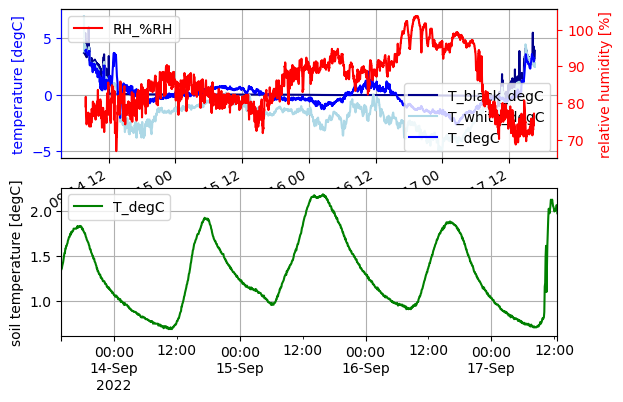

In [29]:
# Radiation
df_rad = Met.read_Campbell_radiation(f"{path_data}Radiation_SEB/TOA5_19688.rad_2022_02_11_1145.dat")
    
fig, ax = plt.subplots(1,1)
with pd.plotting.plot_params.use('x_compat', True):
    df_rad.plot(y="CM3Up_Avg", ax=ax, c="b")
    df_rad.plot(y="CM3Dn_Avg", ax=ax, c="g")
    df_rad.plot(y="CG3UpCo_Avg", ax=ax, c="r")
    df_rad.plot(y="CG3DnCo_Avg", ax=ax, c="orange")
ax.set_xlabel(None)
ax.set_ylabel("irradiance [W/m^2]")
ax.grid("both")
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%b'))



# TinyTags
df_TT = Met.read_Tinytag(f"{path_data}TinyTags/20220917_TT3.txt", "TT")
df_TH = Met.read_Tinytag(f"{path_data}TinyTags/20220917_TH6.txt", "TH")
df_CEB = Met.read_Tinytag(f"{path_data}TinyTags/20220917_CEB1.txt", "CEB")

fig, (ax_T, ax_CEB) = plt.subplots(2,1)
ax_RH = ax_T.twinx()
df_TT.plot(y="T_black_degC", ax=ax_T, c="darkblue")
df_TT.plot(y="T_white_degC", ax=ax_T, c="lightblue")
df_TH.plot(y="T_degC", ax=ax_T, c="b")
df_TH.plot(y="RH_%RH", ax=ax_RH, c="r")
ax_T.set_xlabel(None)
ax_T.set_ylabel("temperature [degC]", c="b")
ax_RH.set_ylabel("relative humidity [%]", c="r")
ax_RH.spines['left'].set_color('b')
ax_RH.spines['right'].set_color('r')
ax_T.tick_params(axis='y', colors="b", labelcolor="b")
ax_RH.tick_params(axis='y', colors="r", labelcolor="r")
ax_T.grid("both")
ax_T.legend(loc="lower right")
ax_RH.legend(loc="upper left")

df_CEB.plot(y="T_degC", ax=ax_CEB, c="g")
ax_CEB.set_xlabel(None)
ax_CEB.set_ylabel("soil temperature [degC]")
ax_CEB.grid()

Besides time series plots, you might want to plot data on a map. Examples are model data from AROME-Arctic or IWIN measurements from the boats on Isfjorden. The Meteo module provides a set of functions to create different kinds of maps, please check the docs and decide, which type might be suited best for your specific plot. An example:

Text(0, 0.5, '2m temperature')

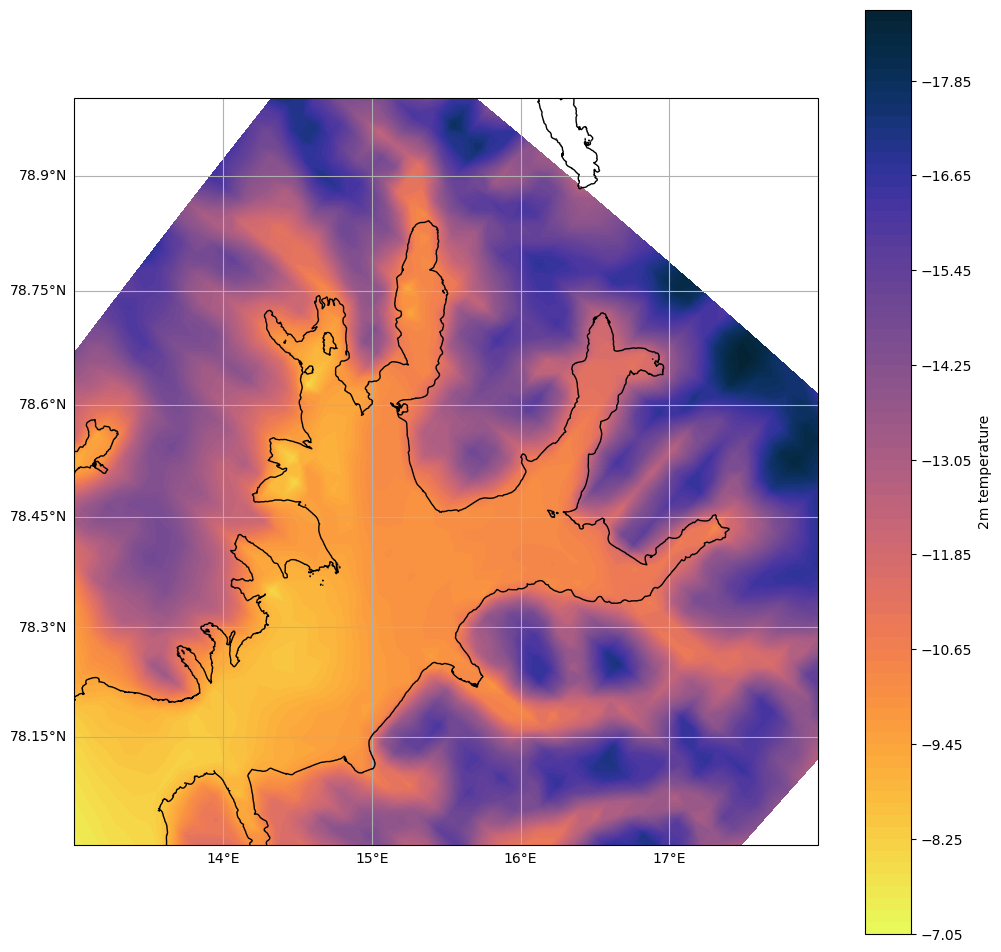

In [30]:
aa = Met.read_AROME(f"{path_data}AROME_ARCTIC/AA_nearsurface_2p5km_20220503.nc")
    
fig, ax = Met.initialize_empty_map(lat_limits=[78., 79.], lon_limits=[13., 18.])
fig, ax = Met.map_add_coastline(fig, ax, option=1, color="k", lat_limits=[78., 79.], lon_limits=[13., 18.], path_mapdata=f"{path_data}Svalbard_map_data/")

pic = ax.contourf(aa.longitude, aa.latitude, aa.air_temperature_2m.sel(time="2022-05-03 12:00:00")-273.15, levels=100, cmap=cmo.cm.thermal, transform=ccrs.PlateCarree())
cbar = plt.colorbar(pic, ax=ax)
cbar.ax.set_ylabel("2m temperature")